In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.016, 0.016, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0003, device='cuda:0')

In [3]:
alpha_

tensor([9.8400e-01, 9.6826e-01, 9.5276e-01, 9.3752e-01, 9.2252e-01, 9.0776e-01,
        8.9324e-01, 8.7894e-01, 8.6488e-01, 8.5104e-01, 8.3743e-01, 8.2403e-01,
        8.1084e-01, 7.9787e-01, 7.8510e-01, 7.7254e-01, 7.6018e-01, 7.4802e-01,
        7.3605e-01, 7.2427e-01, 7.1268e-01, 7.0128e-01, 6.9006e-01, 6.7902e-01,
        6.6816e-01, 6.5747e-01, 6.4695e-01, 6.3659e-01, 6.2641e-01, 6.1639e-01,
        6.0652e-01, 5.9682e-01, 5.8727e-01, 5.7787e-01, 5.6863e-01, 5.5953e-01,
        5.5058e-01, 5.4177e-01, 5.3310e-01, 5.2457e-01, 5.1618e-01, 5.0792e-01,
        4.9979e-01, 4.9180e-01, 4.8393e-01, 4.7618e-01, 4.6857e-01, 4.6107e-01,
        4.5369e-01, 4.4643e-01, 4.3929e-01, 4.3226e-01, 4.2534e-01, 4.1854e-01,
        4.1184e-01, 4.0525e-01, 3.9877e-01, 3.9239e-01, 3.8611e-01, 3.7993e-01,
        3.7385e-01, 3.6787e-01, 3.6199e-01, 3.5619e-01, 3.5050e-01, 3.4489e-01,
        3.3937e-01, 3.3394e-01, 3.2860e-01, 3.2334e-01, 3.1817e-01, 3.1307e-01,
        3.0807e-01, 3.0314e-01, 2.9829e-

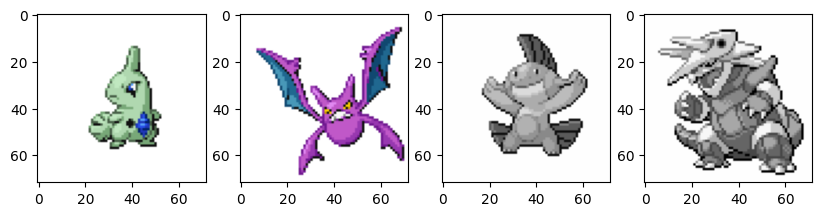

In [4]:
transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64+6, 64+6)),
    v2.Pad(1, 1.0),
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
model = UNet_conditional(3, 3, time_dim=512, num_classes=len(all_types) + 1).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 72, 72), device=device)

    ty = [["Grass", "Poison"], ["Fire", "Water"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

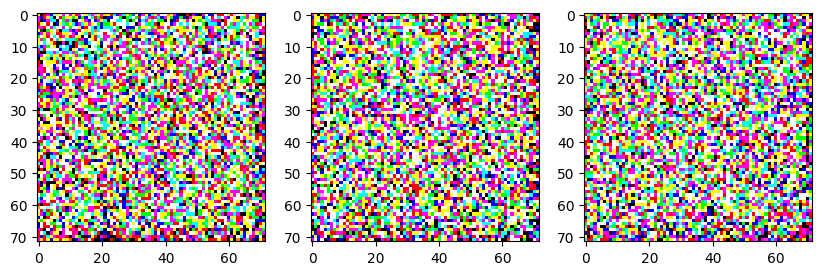

0.05340611:   1%|          | 997/100001 [00:34<51:40, 31.93it/s]  

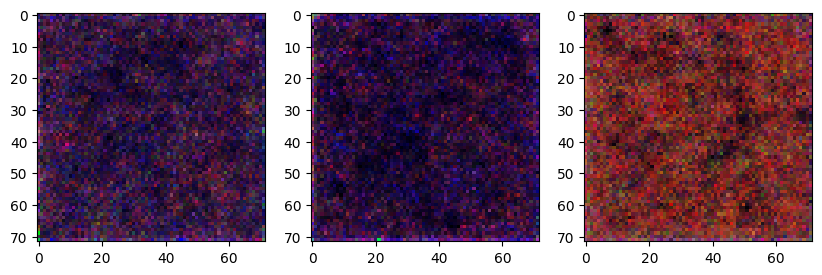

0.05151036:   2%|▏         | 1997/100001 [01:09<51:08, 31.94it/s]  

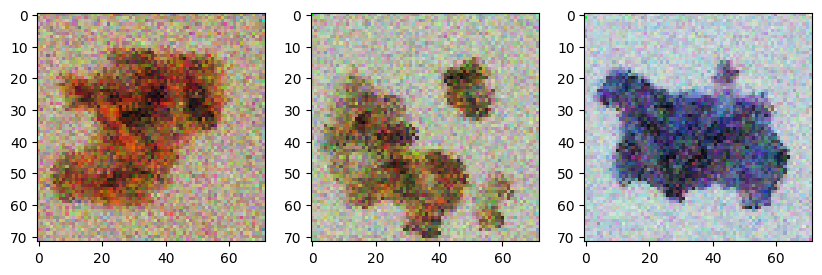

0.02033114:   3%|▎         | 2997/100001 [01:43<50:41, 31.89it/s]  

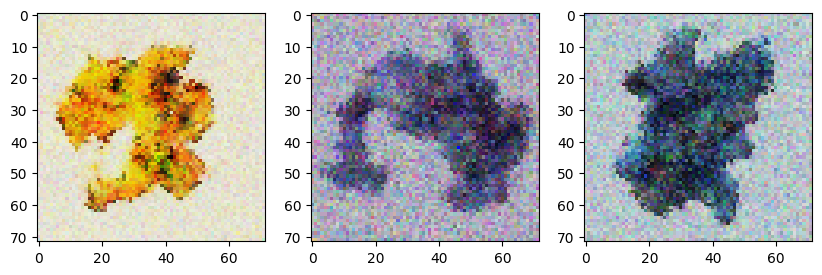

0.01552001:   4%|▍         | 3997/100001 [02:18<50:01, 31.99it/s]  

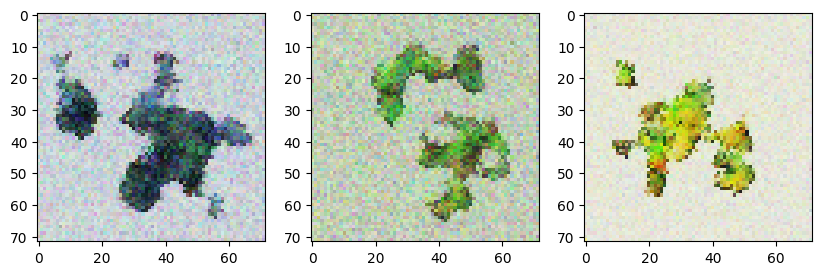

0.03716650:   5%|▍         | 4997/100001 [02:53<49:40, 31.87it/s]  

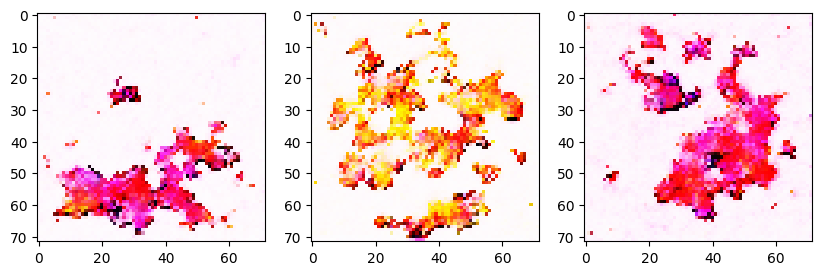

0.02241145:   6%|▌         | 5997/100001 [03:27<49:09, 31.87it/s]  

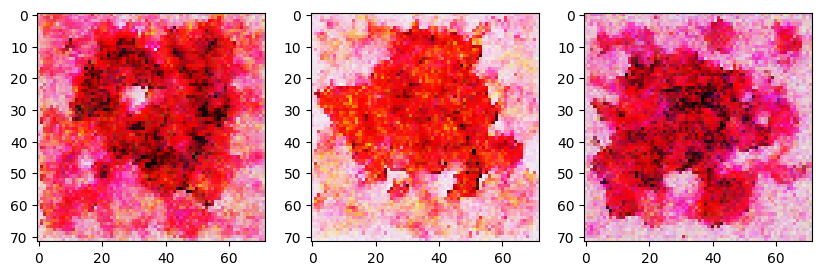

0.02528783:   7%|▋         | 6997/100001 [04:02<48:33, 31.92it/s]  

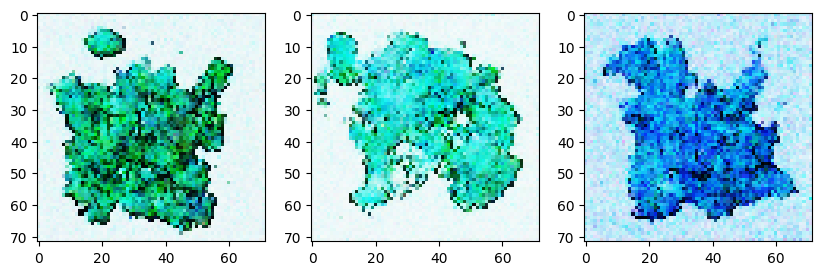

0.01013628:   8%|▊         | 7997/100001 [04:36<48:04, 31.90it/s]  

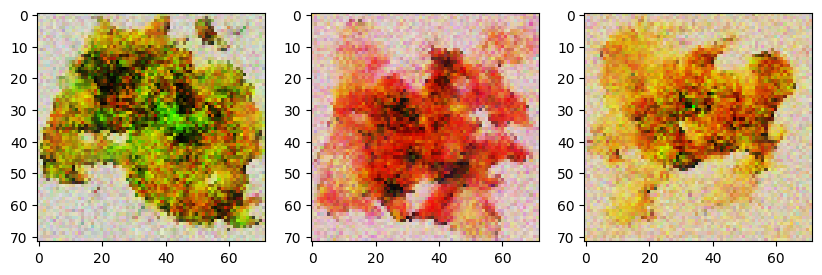

0.02834258:   9%|▉         | 8997/100001 [05:11<47:40, 31.82it/s]  

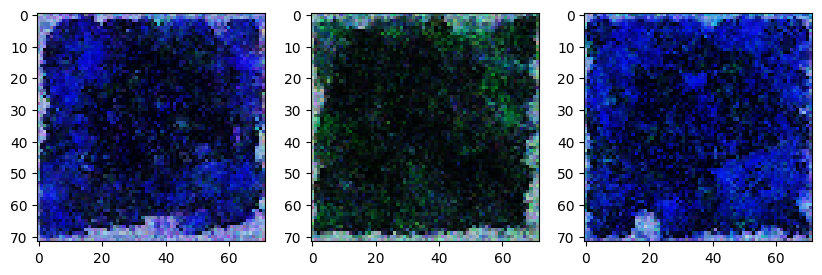

0.02271131:  10%|▉         | 9997/100001 [05:45<46:59, 31.92it/s]  

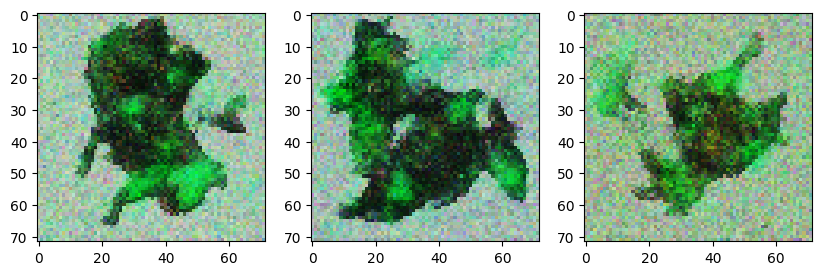

0.02163989:  11%|█         | 10997/100001 [06:20<46:29, 31.90it/s]  

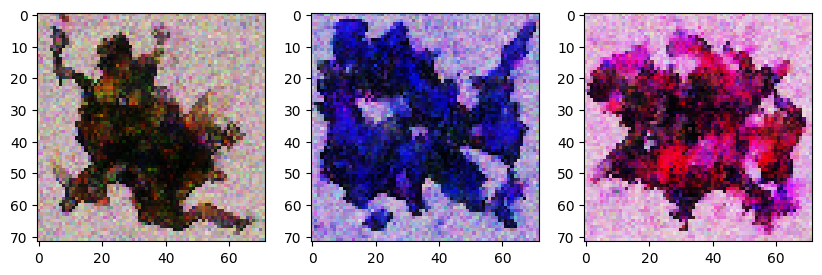

0.04760509:  12%|█▏        | 11997/100001 [06:55<45:59, 31.89it/s]  

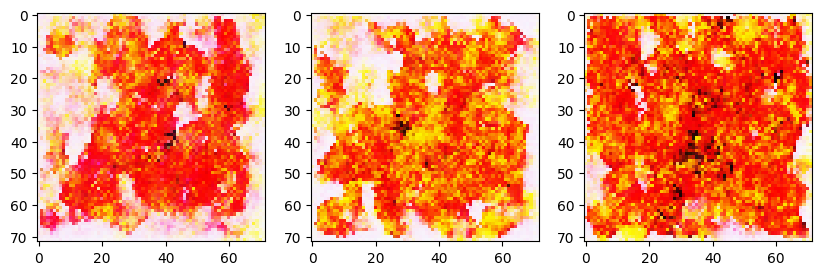

0.04378368:  13%|█▎        | 12997/100001 [07:29<45:30, 31.87it/s]  

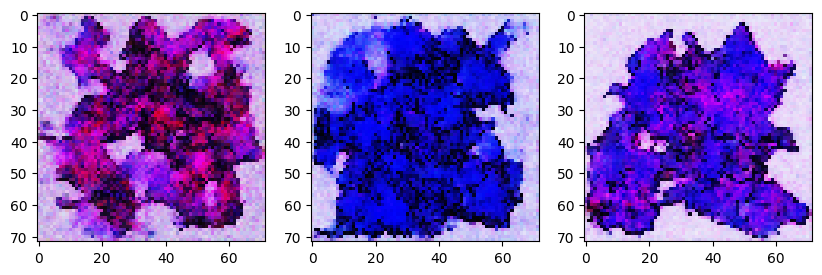

0.02197405:  14%|█▍        | 13997/100001 [08:04<44:57, 31.88it/s]  

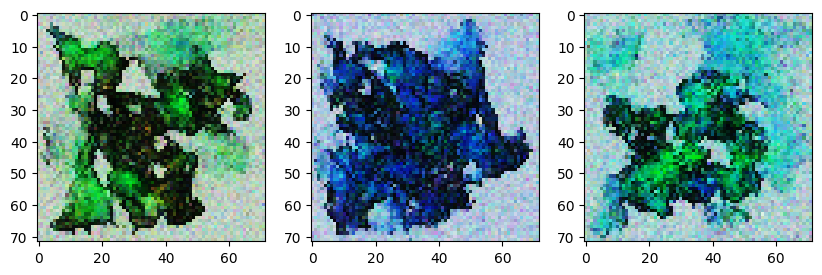

0.03300933:  15%|█▍        | 14997/100001 [08:38<44:23, 31.92it/s]  

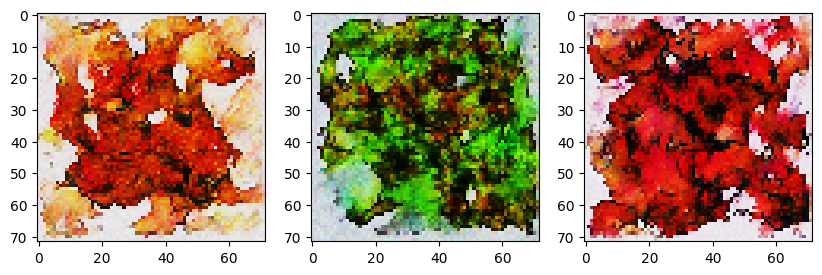

0.02715327:  16%|█▌        | 15997/100001 [09:13<43:48, 31.96it/s]  

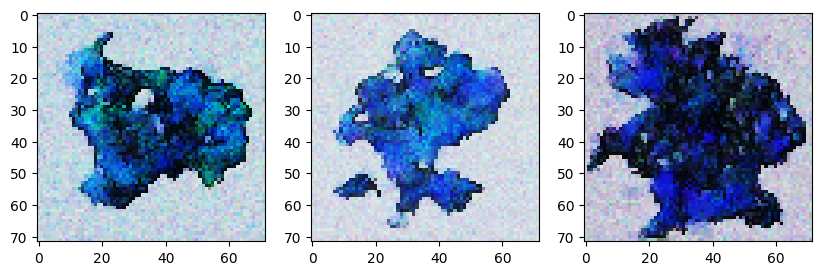

0.01304676:  17%|█▋        | 16997/100001 [09:47<43:18, 31.95it/s]  

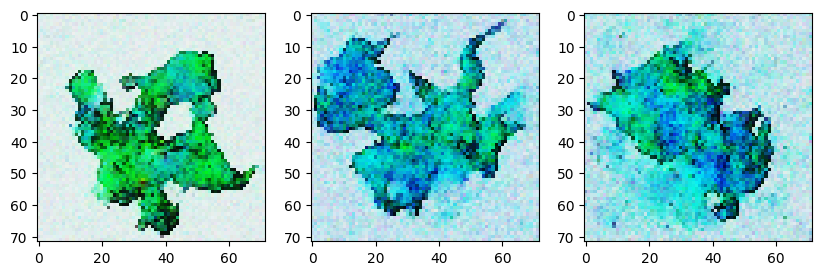

0.01760961:  18%|█▊        | 17997/100001 [10:22<42:50, 31.90it/s]  

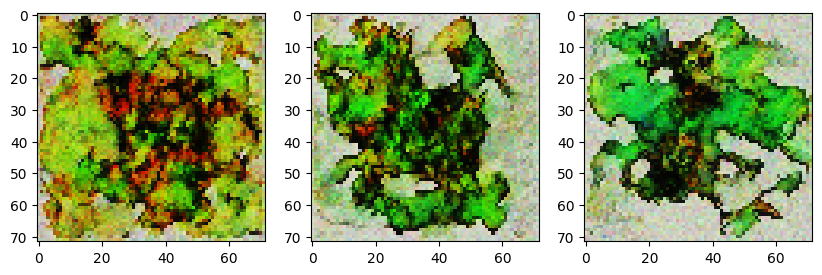

0.01509444:  19%|█▉        | 18997/100001 [10:56<42:19, 31.90it/s]  

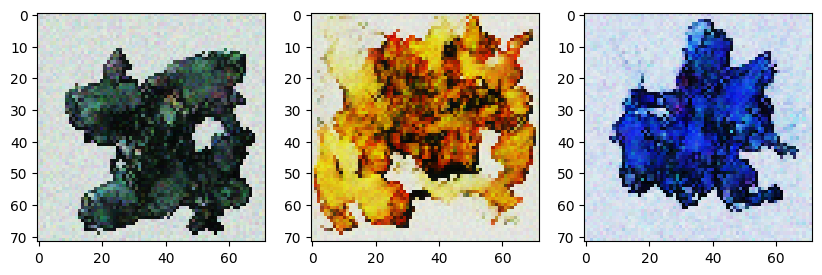

0.02100209:  20%|█▉        | 19997/100001 [11:31<41:53, 31.83it/s]  

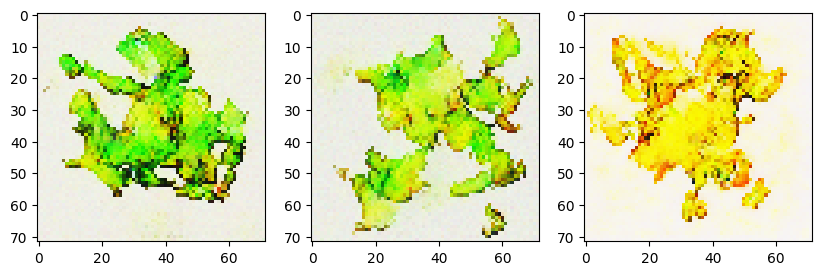

0.02521922:  21%|██        | 20997/100001 [12:06<41:24, 31.80it/s]  

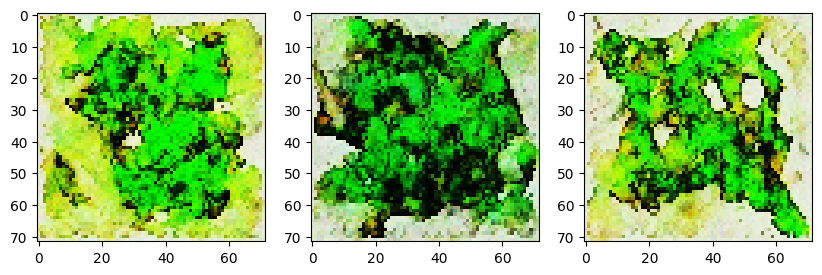

0.05824398:  22%|██▏       | 21997/100001 [12:40<40:47, 31.87it/s]  

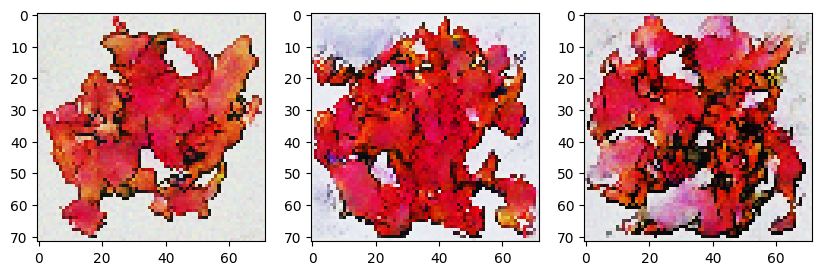

0.02257485:  23%|██▎       | 22997/100001 [13:15<40:16, 31.86it/s]  

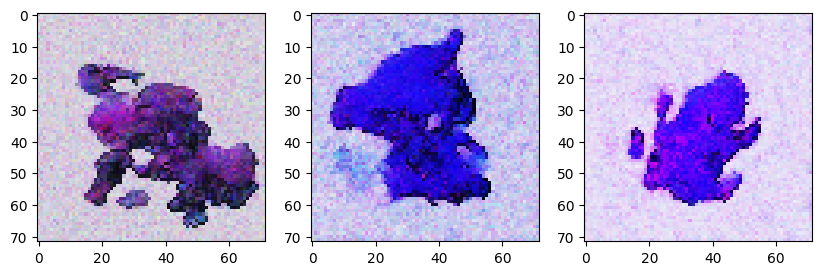

0.00666025:  24%|██▍       | 23997/100001 [13:49<39:36, 31.98it/s]  

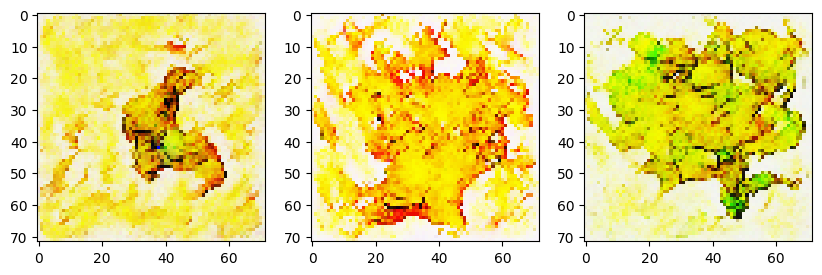

0.04804238:  25%|██▍       | 24997/100001 [14:24<39:11, 31.90it/s]  

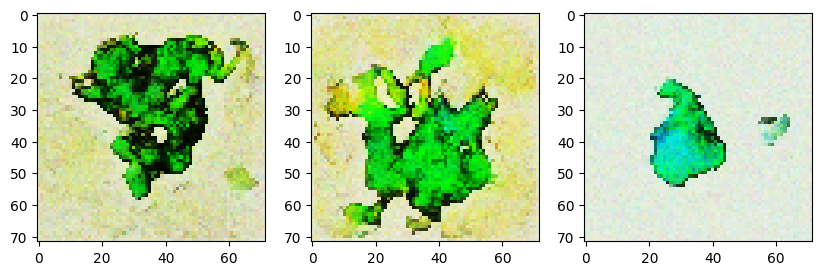

0.03358096:  26%|██▌       | 25997/100001 [14:59<38:46, 31.82it/s]  

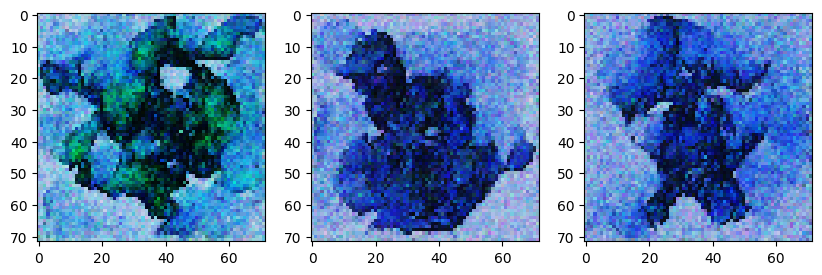

0.00701921:  27%|██▋       | 26997/100001 [15:33<38:11, 31.85it/s]  

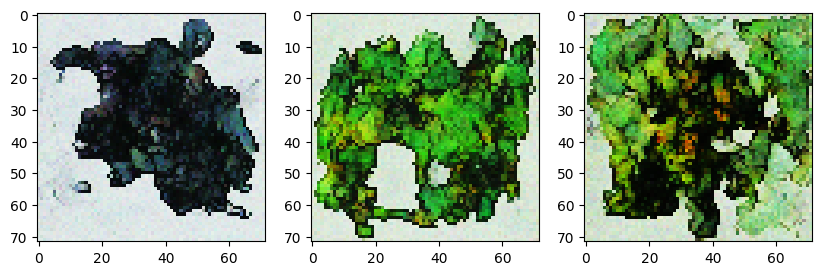

0.01365895:  28%|██▊       | 27997/100001 [16:08<37:36, 31.92it/s]  

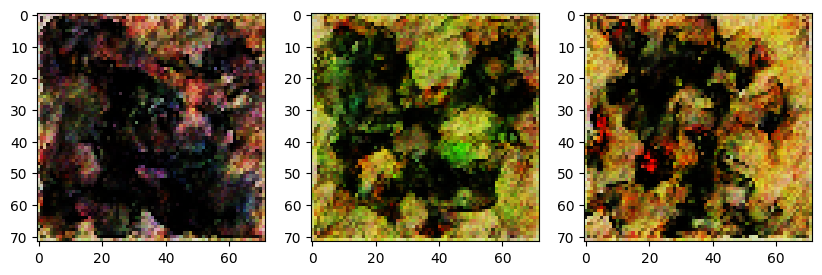

0.04336344:  29%|██▉       | 28997/100001 [16:42<37:05, 31.90it/s]  

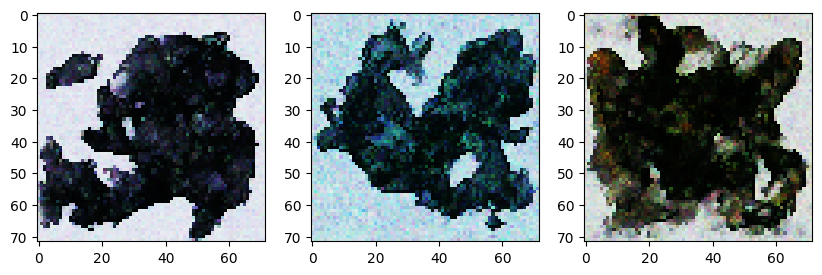

0.01791210:  30%|██▉       | 29997/100001 [17:17<36:32, 31.93it/s]  

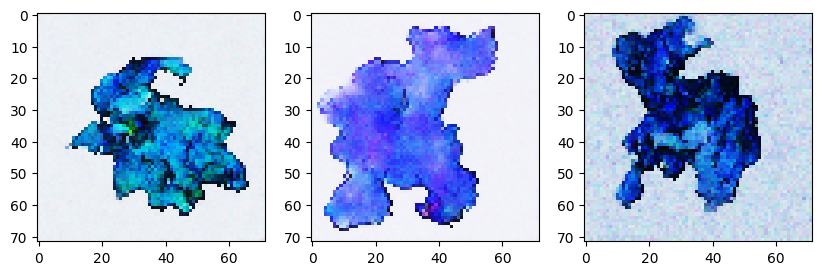

0.02149433:  31%|███       | 30997/100001 [17:51<36:01, 31.93it/s]  

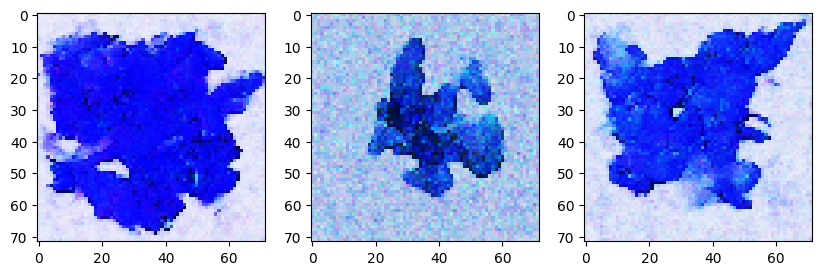

0.01851288:  32%|███▏      | 31997/100001 [18:26<35:29, 31.93it/s]  

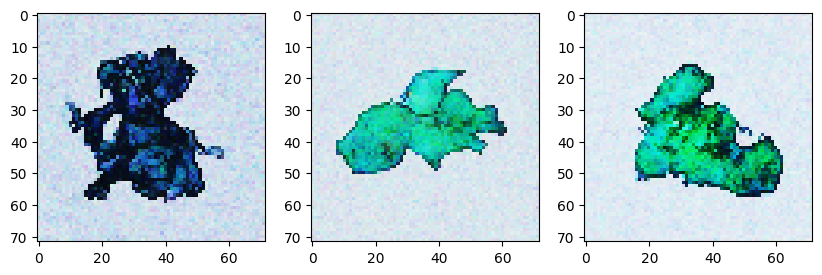

0.02303887:  33%|███▎      | 32997/100001 [19:00<35:00, 31.90it/s]  

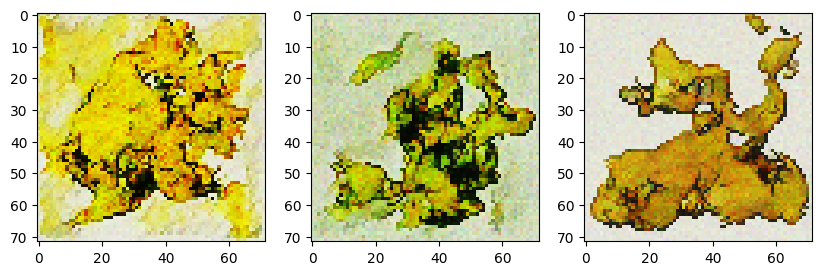

0.02341707:  34%|███▍      | 33997/100001 [19:35<34:25, 31.96it/s]  

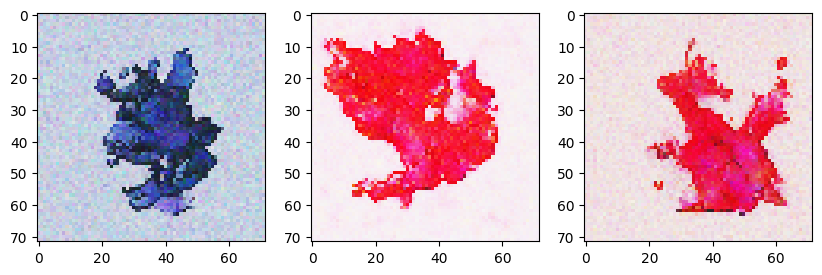

0.01290751:  35%|███▍      | 34997/100001 [20:09<33:54, 31.95it/s]  

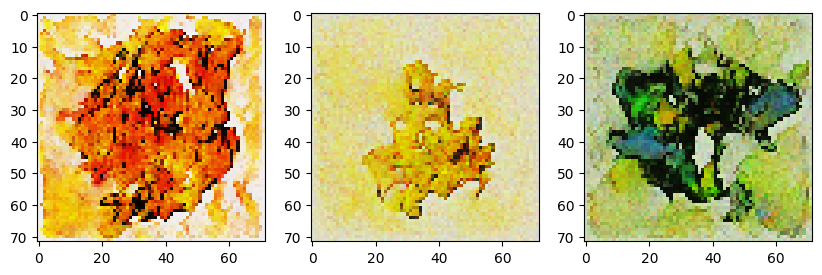

0.02264222:  36%|███▌      | 35997/100001 [20:44<33:23, 31.95it/s]  

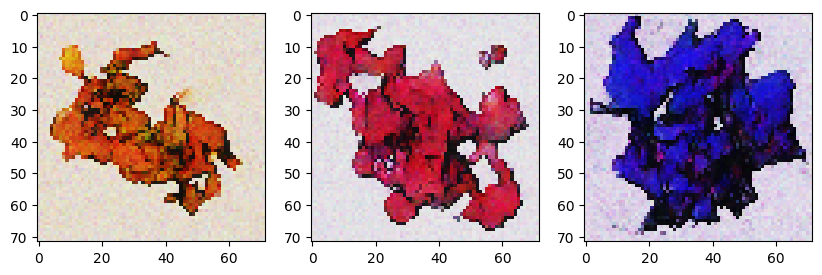

0.02390333:  37%|███▋      | 36997/100001 [21:18<32:57, 31.86it/s]  

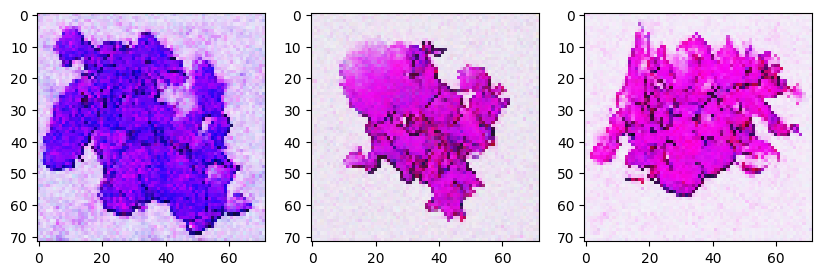

0.02874567:  38%|███▊      | 37997/100001 [21:53<32:32, 31.75it/s]  

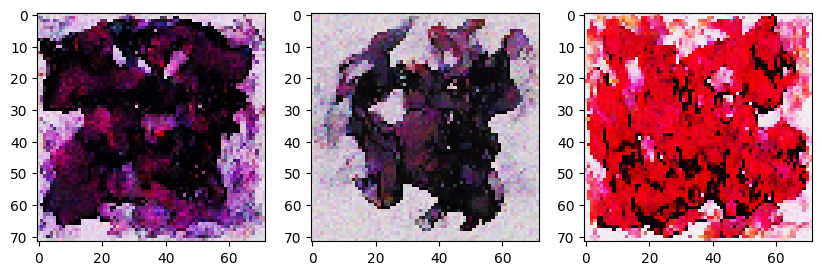

0.02001800:  39%|███▉      | 38997/100001 [22:28<31:55, 31.85it/s]  

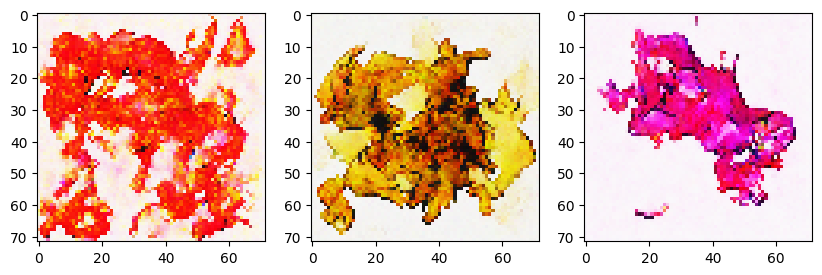

0.01952355:  40%|███▉      | 39997/100001 [23:03<31:23, 31.86it/s]  

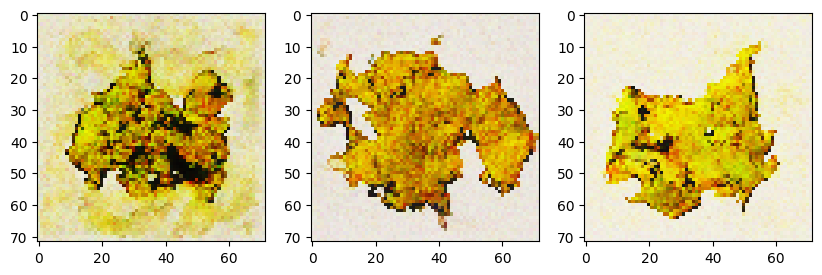

0.02589675:  41%|████      | 40997/100001 [23:37<30:55, 31.80it/s]  

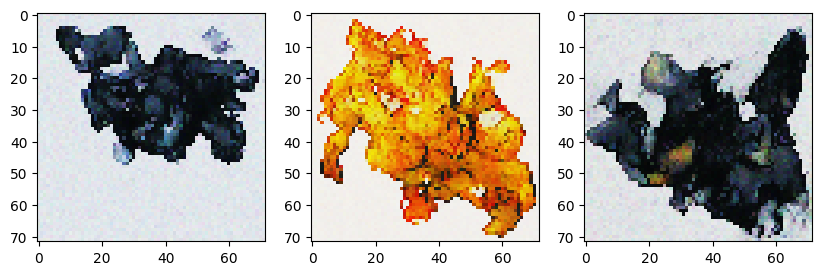

0.01650384:  42%|████▏     | 41997/100001 [24:12<30:23, 31.81it/s]  

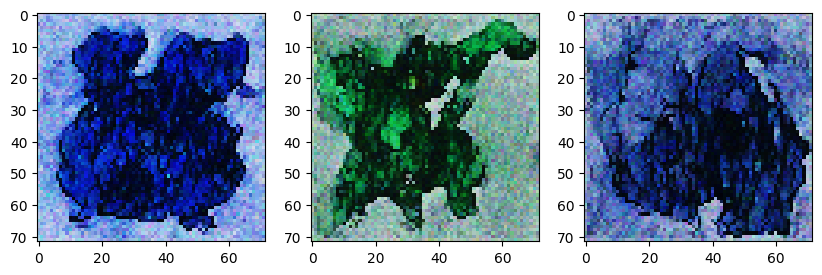

0.02380366:  43%|████▎     | 42997/100001 [24:47<29:49, 31.85it/s]  

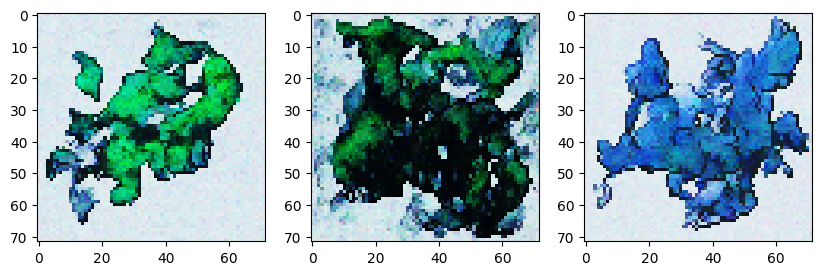

0.01246935:  44%|████▍     | 43997/100001 [25:21<29:15, 31.89it/s]  

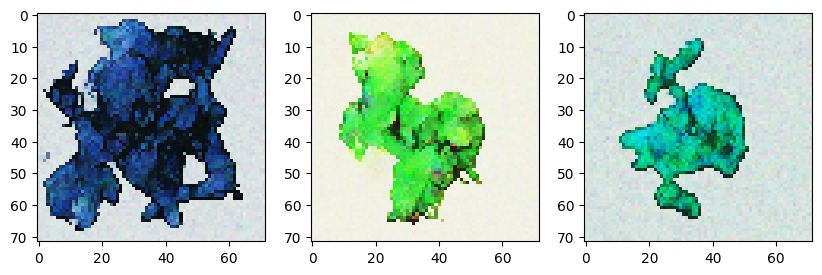

0.04408001:  45%|████▍     | 44997/100001 [25:56<28:48, 31.83it/s]  

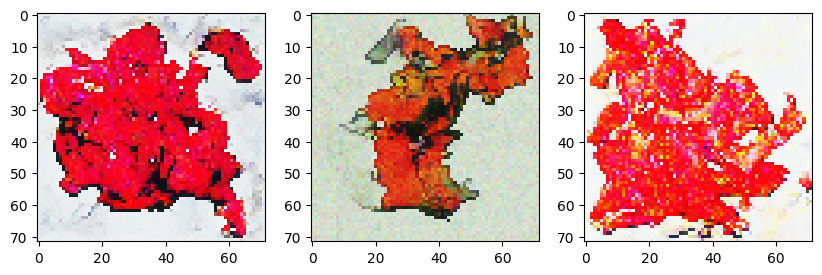

0.01425945:  46%|████▌     | 45997/100001 [26:31<28:13, 31.89it/s]  

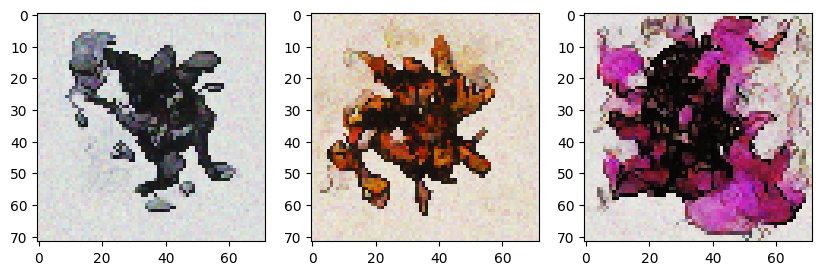

0.01378302:  47%|████▋     | 46997/100001 [27:05<27:52, 31.70it/s]  

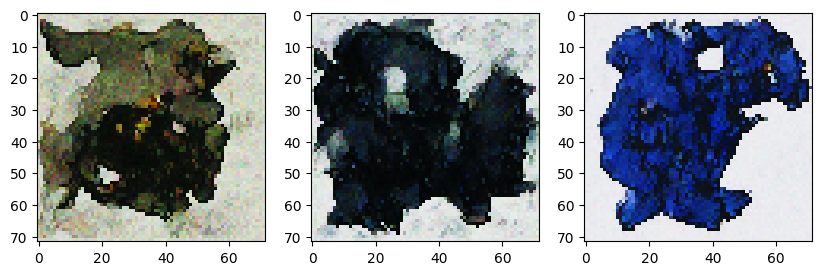

0.02324796:  48%|████▊     | 47997/100001 [27:40<27:16, 31.77it/s]  

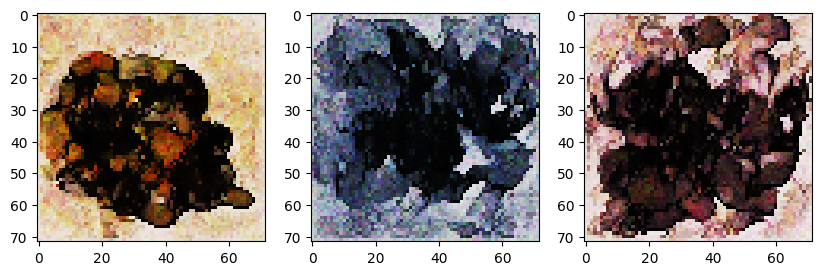

0.02154606:  49%|████▉     | 48997/100001 [28:15<26:41, 31.86it/s]  

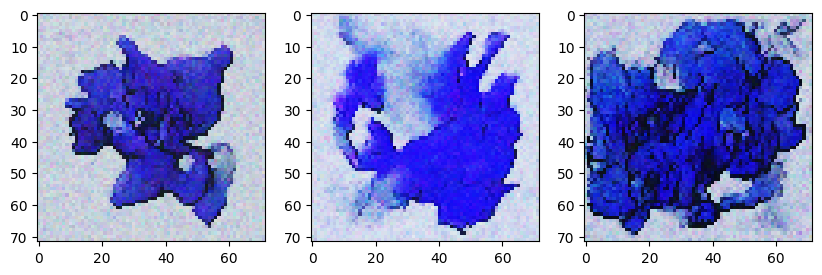

0.01431506:  50%|████▉     | 49997/100001 [28:49<26:09, 31.87it/s]  

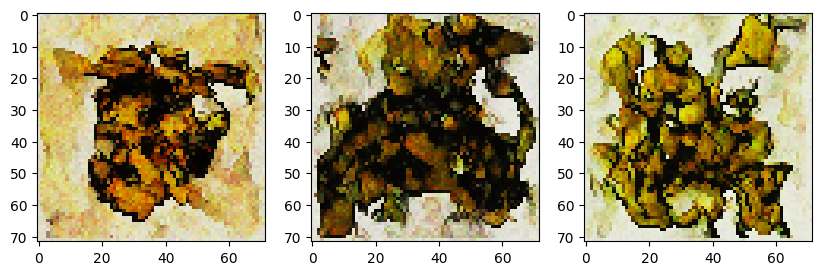

0.01291747:  51%|█████     | 50997/100001 [29:24<25:36, 31.90it/s]  

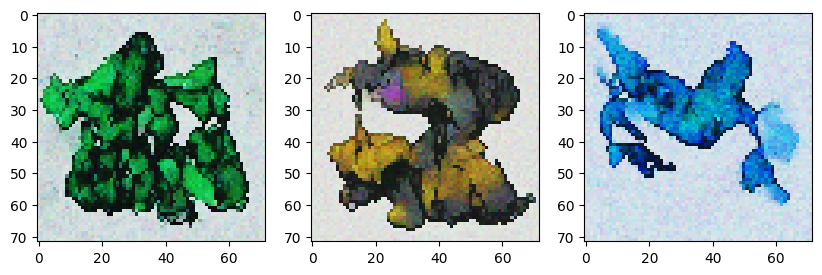

0.02265716:  52%|█████▏    | 51997/100001 [29:58<25:08, 31.82it/s]  

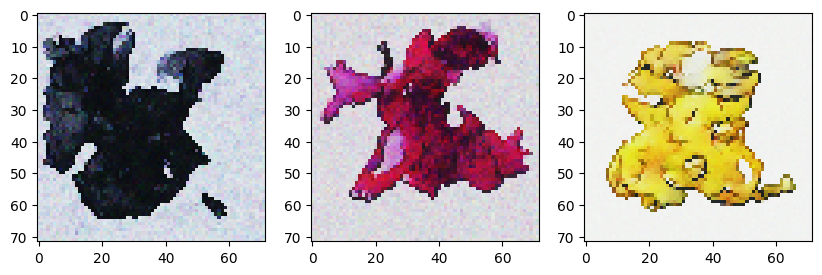

0.01409942:  53%|█████▎    | 52997/100001 [30:33<24:34, 31.89it/s]  

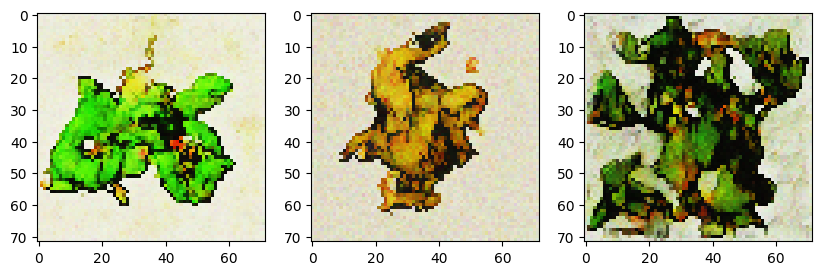

0.01378916:  54%|█████▍    | 53997/100001 [31:08<24:13, 31.66it/s]  

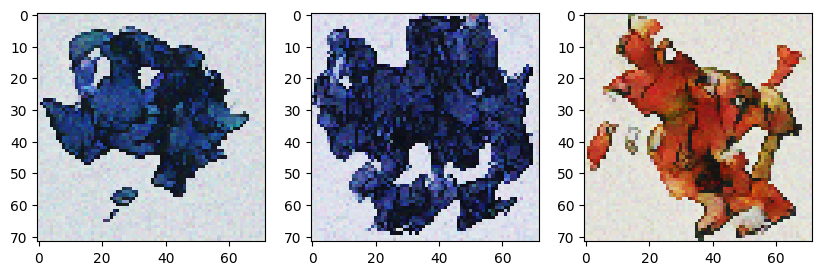

0.03167041:  55%|█████▍    | 54997/100001 [31:42<23:31, 31.88it/s]  

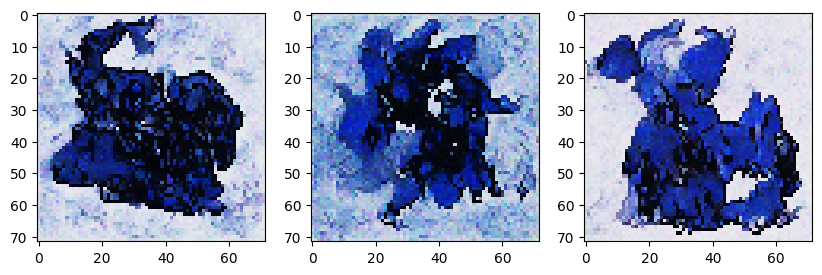

0.02072841:  56%|█████▌    | 55997/100001 [32:17<23:05, 31.76it/s]  

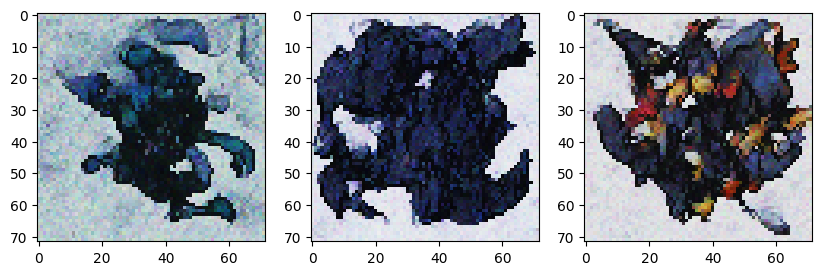

0.00403745:  57%|█████▋    | 56997/100001 [32:52<22:28, 31.90it/s]  

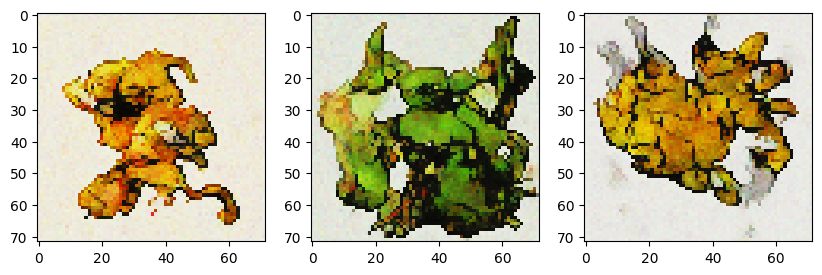

0.01459483:  58%|█████▊    | 58000/100001 [33:26<21:57, 31.89it/s]  

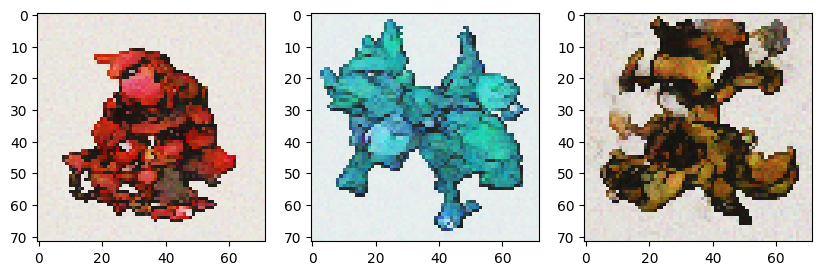

0.01830416:  59%|█████▉    | 59000/100001 [34:01<21:25, 31.89it/s]  

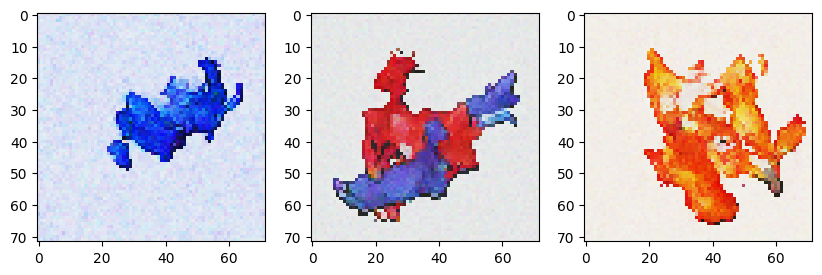

0.01912305:  60%|█████▉    | 60000/100001 [34:36<20:55, 31.85it/s]  

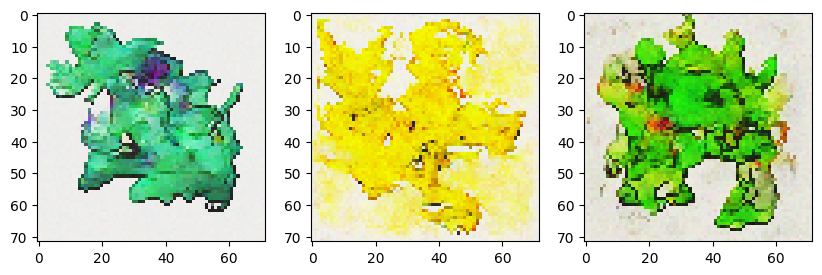

0.03046808:  61%|██████    | 61000/100001 [35:10<20:21, 31.93it/s]  

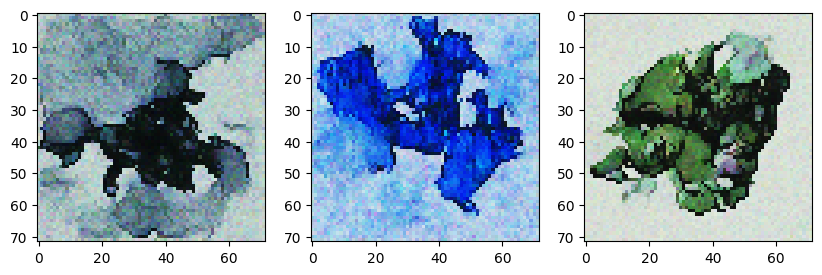

0.01400048:  62%|██████▏   | 62000/100001 [35:45<19:53, 31.84it/s]  

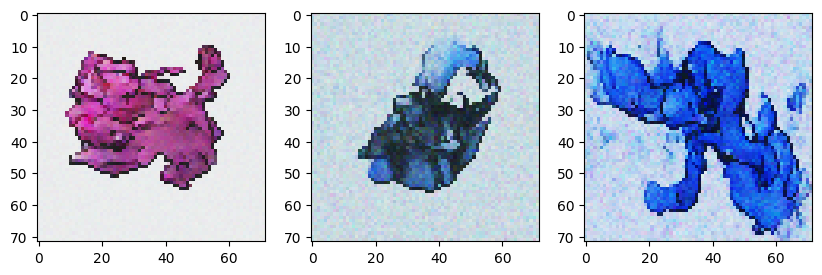

0.02073868:  63%|██████▎   | 63000/100001 [36:20<19:28, 31.65it/s]  

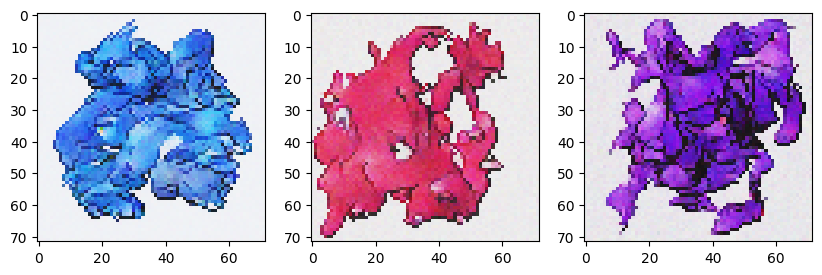

0.02899500:  64%|██████▍   | 64000/100001 [36:54<18:50, 31.83it/s]  

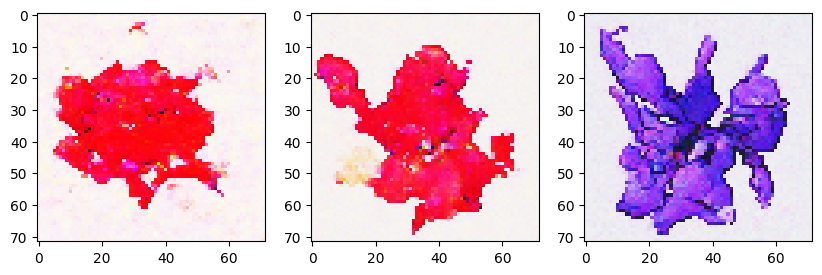

0.00659926:  65%|██████▍   | 65000/100001 [37:29<18:18, 31.85it/s]  

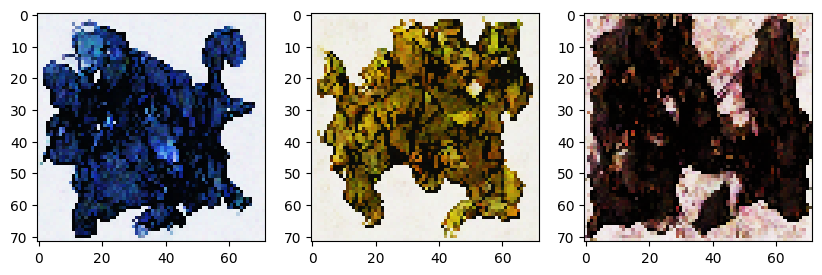

0.01609202:  66%|██████▌   | 66000/100001 [38:04<17:53, 31.67it/s]  

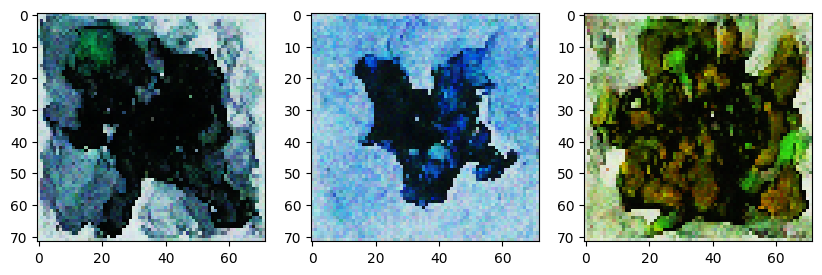

0.01322839:  67%|██████▋   | 67000/100001 [38:38<17:12, 31.95it/s]  

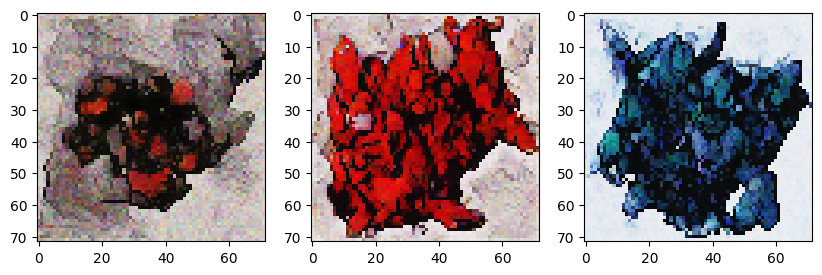

0.01455766:  68%|██████▊   | 68000/100001 [39:13<16:47, 31.76it/s]  

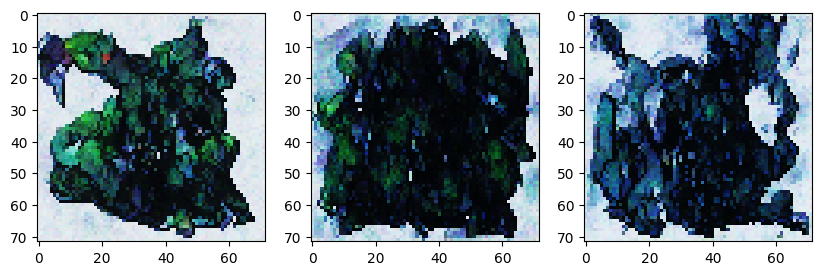

0.01624849:  69%|██████▉   | 69000/100001 [39:48<16:15, 31.78it/s]  

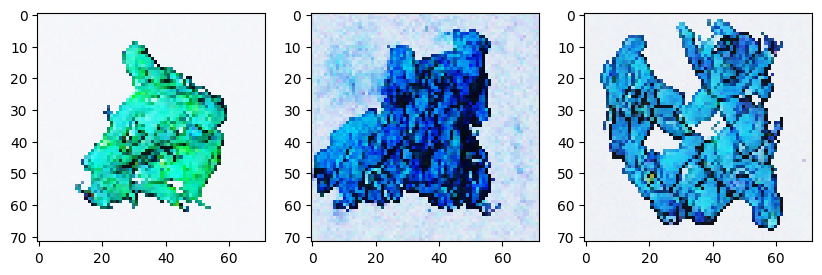

0.01765046:  70%|██████▉   | 70000/100001 [40:22<16:01, 31.19it/s]  

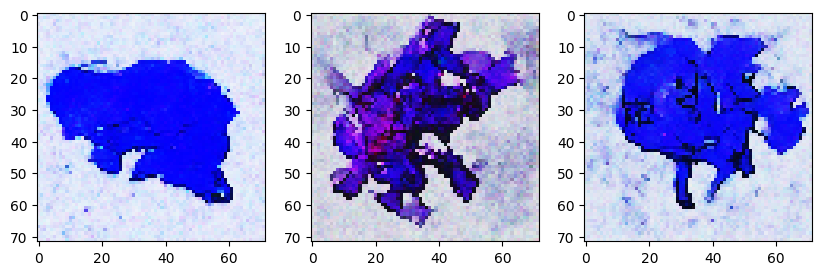

0.01593377:  71%|███████   | 71000/100001 [40:57<15:10, 31.86it/s]  

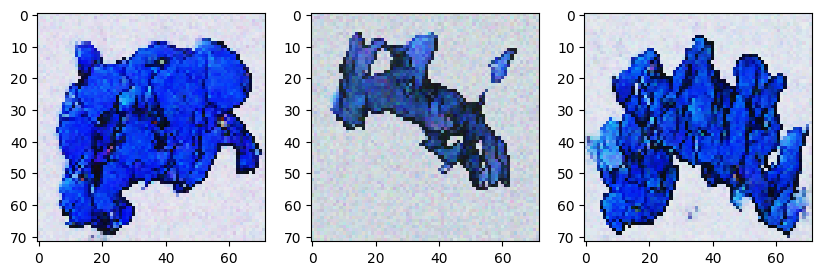

0.00637712:  72%|███████▏  | 72000/100001 [41:32<14:45, 31.63it/s]  

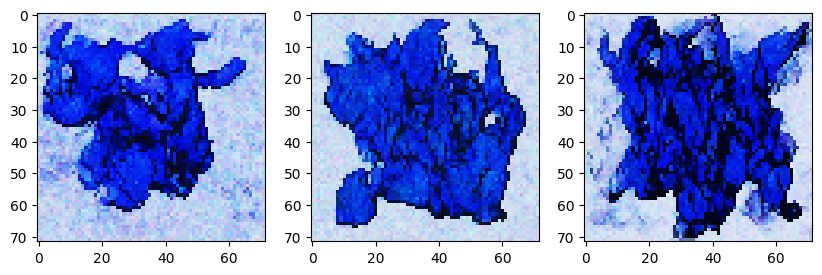

0.02011809:  73%|███████▎  | 73000/100001 [42:06<14:12, 31.67it/s]  

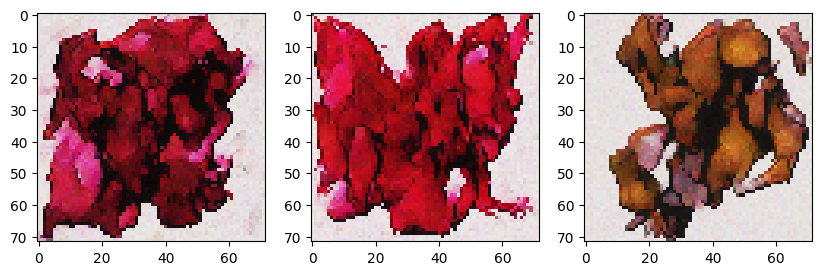

0.01416216:  74%|███████▍  | 74000/100001 [42:41<13:34, 31.91it/s]  

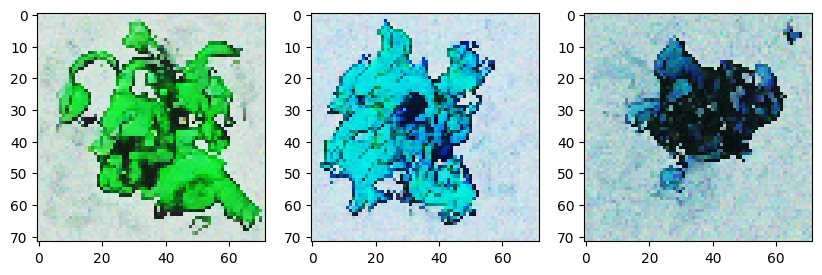

0.01393782:  75%|███████▍  | 75000/100001 [43:16<13:19, 31.28it/s]  

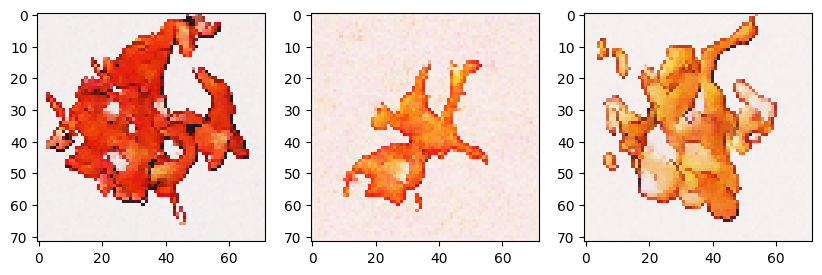

0.01280497:  76%|███████▌  | 76000/100001 [43:51<12:33, 31.87it/s]  

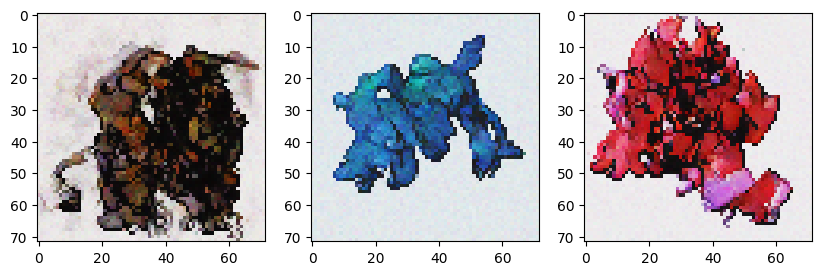

0.01686566:  77%|███████▋  | 77000/100001 [44:26<12:04, 31.76it/s]  

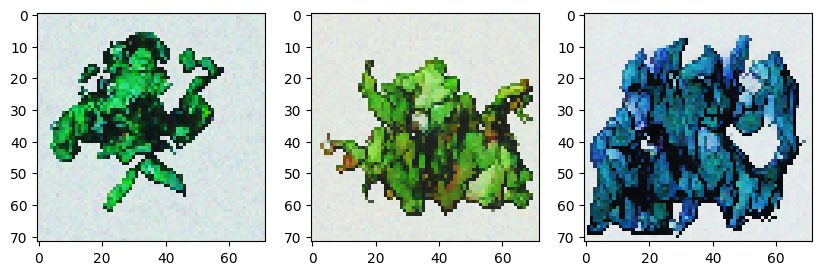

0.00955530:  78%|███████▊  | 78000/100001 [45:00<11:34, 31.67it/s]  

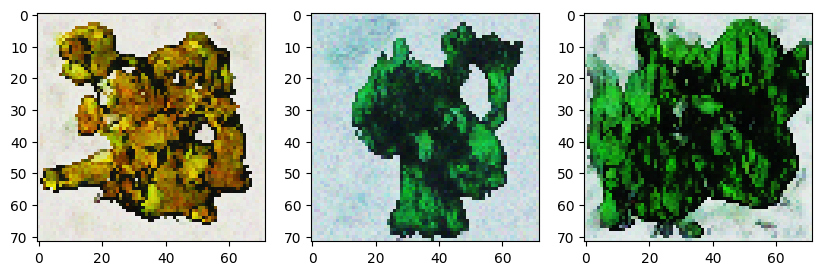

0.00769355:  79%|███████▉  | 79000/100001 [45:35<11:13, 31.17it/s]  

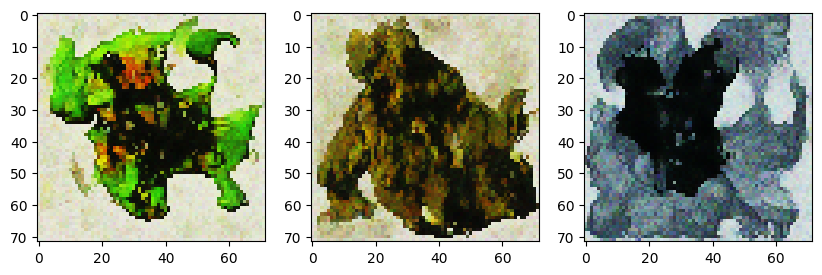

0.02504209:  80%|███████▉  | 79999/100001 [46:11<10:28, 31.81it/s]  

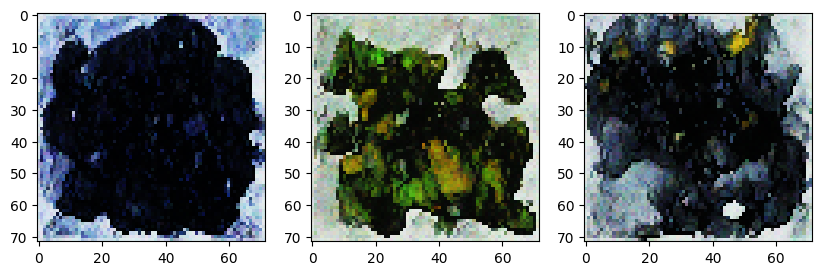

0.01108394:  81%|████████  | 80998/100001 [46:47<10:25, 30.39it/s]  

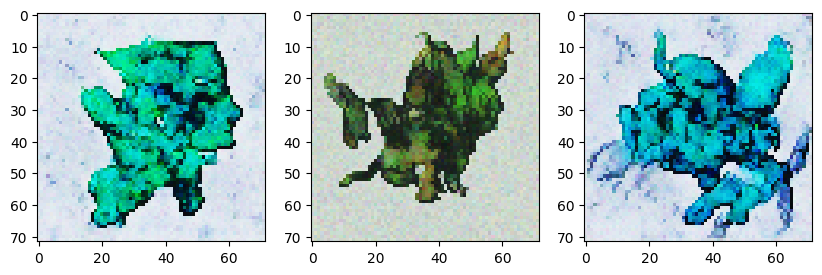

0.01087260:  82%|████████▏ | 81998/100001 [47:23<10:34, 28.36it/s]  

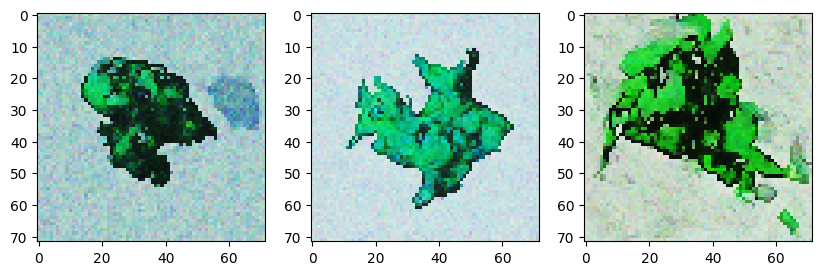

0.01052293:  83%|████████▎ | 82997/100001 [48:00<08:57, 31.66it/s]  

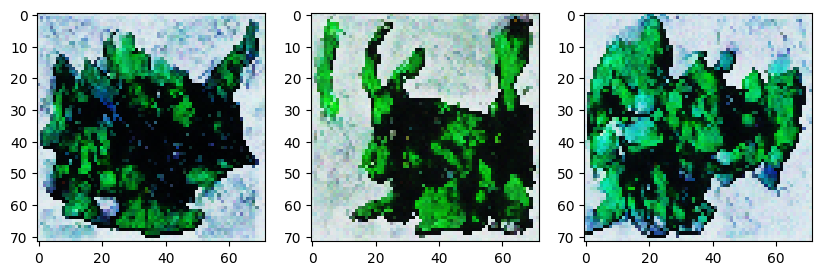

0.02981222:  84%|████████▍ | 83998/100001 [48:38<09:25, 28.29it/s]  

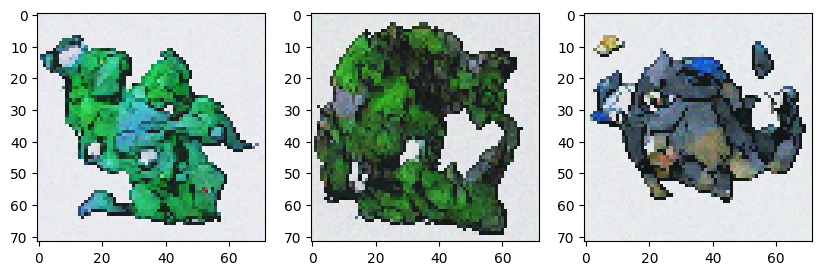

0.01351573:  85%|████████▍ | 84998/100001 [49:16<08:41, 28.76it/s]  

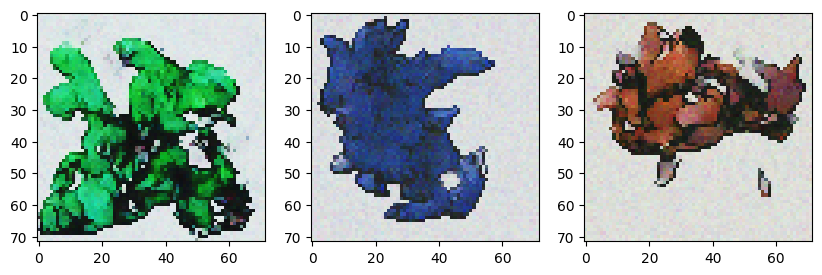

0.02047091:  86%|████████▌ | 86000/100001 [49:56<07:35, 30.73it/s]  

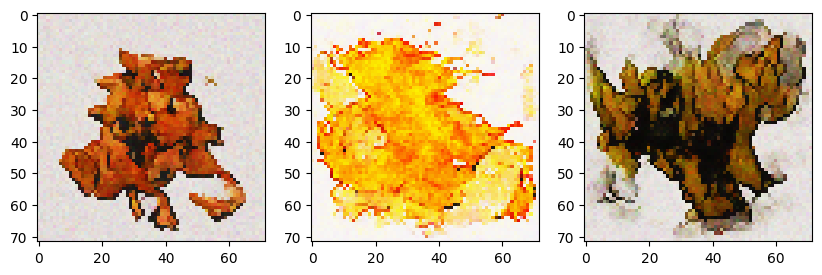

0.02099659:  87%|████████▋ | 87000/100001 [50:36<07:58, 27.17it/s]  

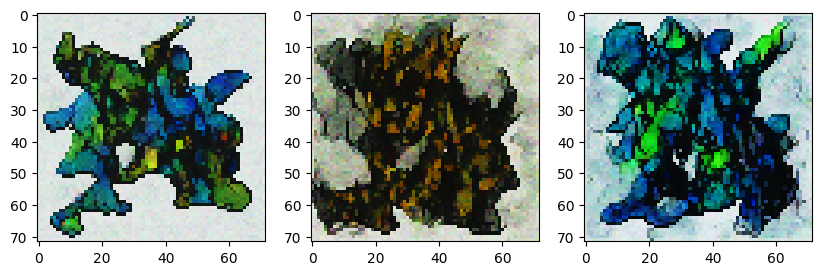

0.01357917:  88%|████████▊ | 88000/100001 [51:17<07:33, 26.49it/s]  

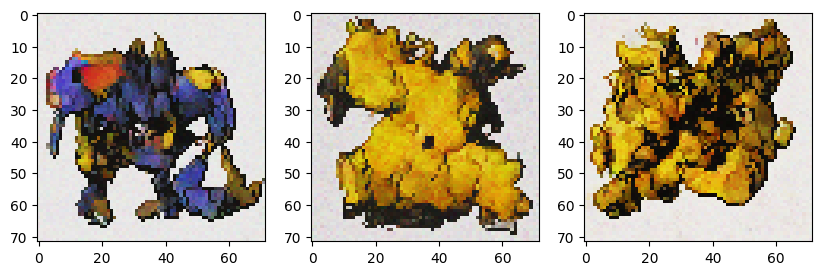

0.02225428:  89%|████████▉ | 89000/100001 [51:59<06:58, 26.27it/s]  

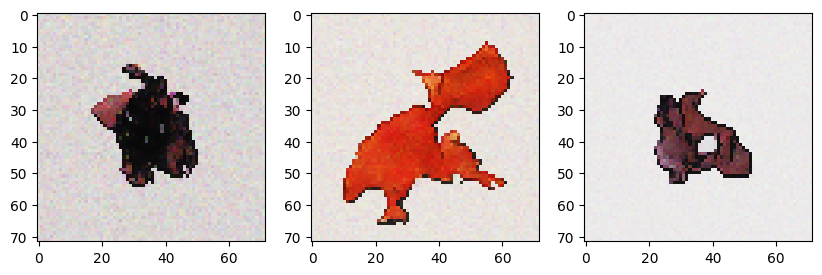

0.02350070:  90%|████████▉ | 89999/100001 [52:40<06:22, 26.15it/s]  

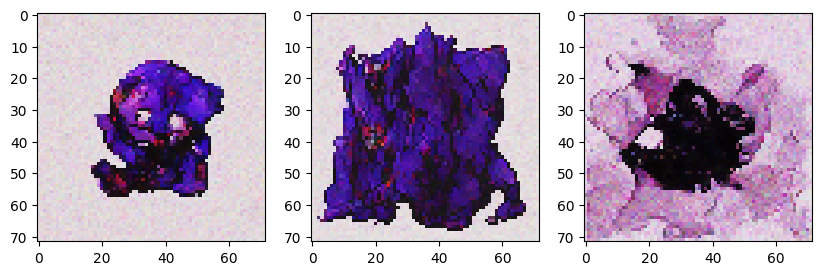

0.02178039:  91%|█████████ | 90999/100001 [53:21<05:38, 26.60it/s]  

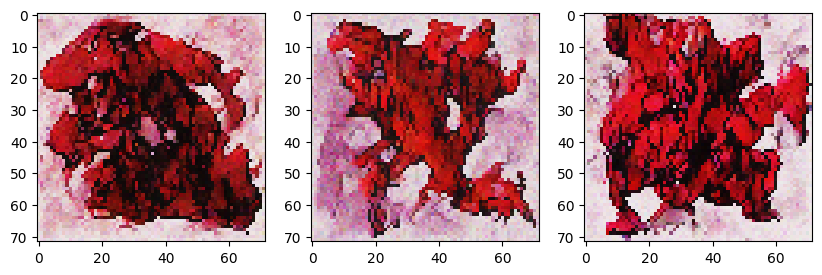

0.01936971:  92%|█████████▏| 91999/100001 [54:03<04:58, 26.82it/s]  

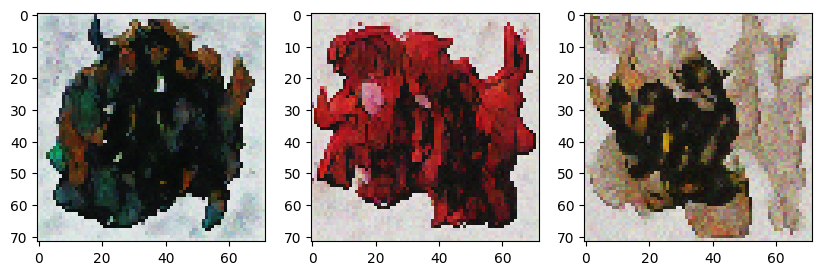

0.01689871:  93%|█████████▎| 92999/100001 [54:44<04:18, 27.05it/s]

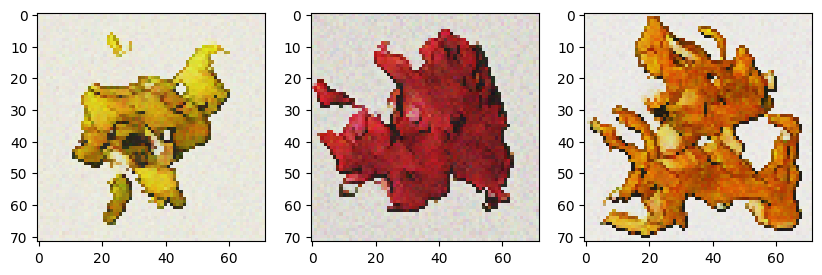

0.01254325:  94%|█████████▍| 94000/100001 [55:26<03:44, 26.77it/s]

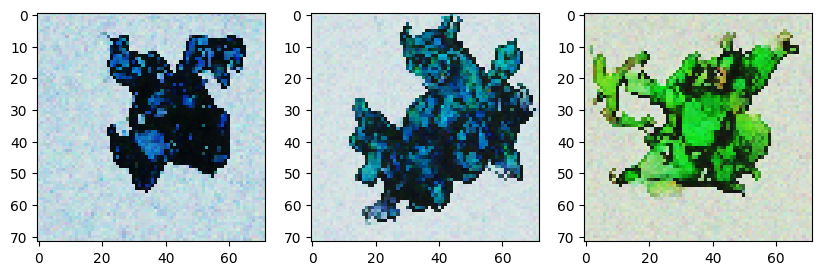

0.01888478:  95%|█████████▍| 95000/100001 [56:08<03:10, 26.28it/s]

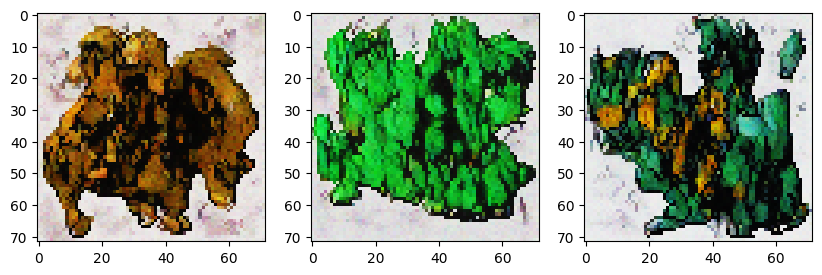

0.01734431:  96%|█████████▌| 95998/100001 [56:49<02:30, 26.60it/s]

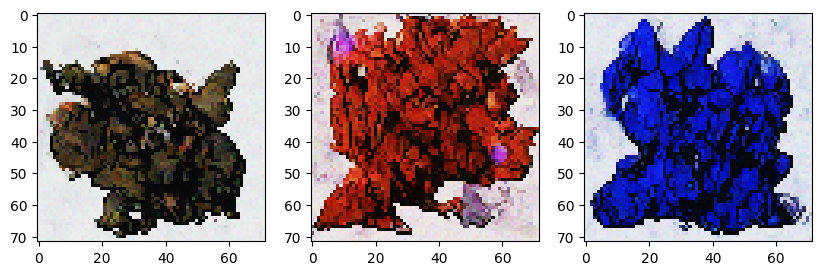

0.00429376:  97%|█████████▋| 96999/100001 [57:31<01:54, 26.11it/s]

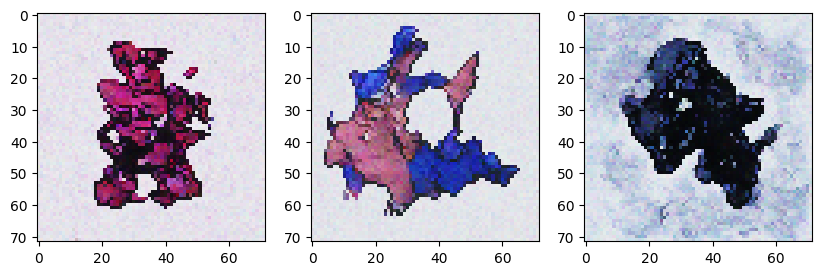

0.00851002:  98%|█████████▊| 98000/100001 [58:13<01:14, 26.95it/s]

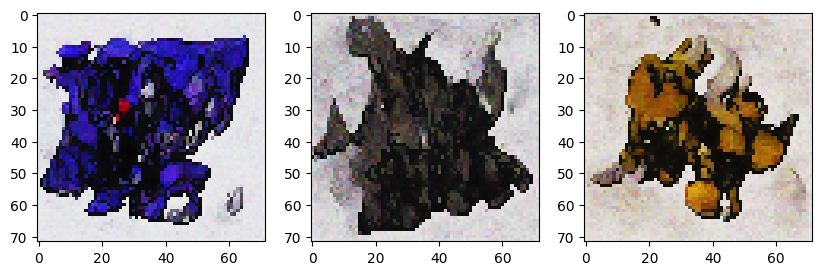

0.01285760:  99%|█████████▉| 99000/100001 [58:54<00:38, 25.97it/s]

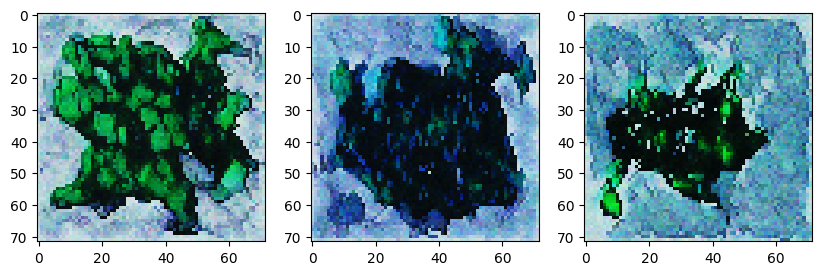

0.02123049: 100%|█████████▉| 99998/100001 [59:36<00:00, 26.22it/s]

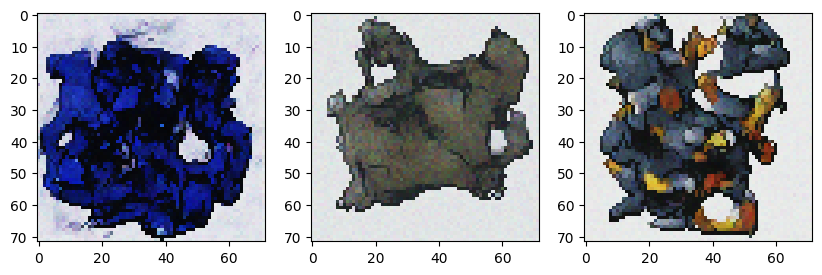

0.01994085: 100%|██████████| 100001/100001 [59:40<00:00, 27.93it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]
    
    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')